# The stochastic optimal growth model with the collocation method + Gaussian quadrature approximation

The purpose of this notebook is to demonstrate how to implement the collocation method for functional approximation and Gaussian quadrature method for the approximation of expectation.

The original set up is based on [the notebook by QuantEcon](https://julia.quantecon.org/dynamic_programming/optgrowth.html).
It uses the interpolation approximation and Monte Carlo approximation.
I contrast these two implementations from the run-time and accuracy perspectives.

## The model

Consider an agent with an amount $y_t$ of a consumption good at period $t$.
This can be used for productive investment or consumption.

With a production shock, $\xi_t$, the next period output is

$$
    y_{t + 1} = f(k_{t + 1}) \xi_{t + 1},
$$

where $f$ is the production function.

The resource constraint is 

$$
    k_{t + 1} + c_t \le y_t.
$$

For more details on the set up, refer to [the original notebook](https://julia.quantecon.org/dynamic_programming/optgrowth.html).

## Optimization

Taking $y_0$ as given, the agent maximizes
$$
    E \left[ \sum_{t = 0}^{\infty} \beta^t u(c_t) \right]
$$

subject to 

$$
    y_{t + 1} = f(y_t - c_t) \xi_{t + 1} \quad \forall t \\
    0 \le c_t \le y_t \quad \forall t.
$$

The Bellman equation takes the form

$$
    w(y) = \max_{0 \le c \le y} \left\{ u(c) + \beta E\left[w \left( f(y - c) \xi \right) \right] \right\}.
$$

## Computation

In [1]:
using Pkg

In [381]:
using LinearAlgebra, Statistics
using LaTeXStrings, Plots, QuantEcon, Interpolations, CompEcon
using NLsolve, Optim, Random, Parameters
using BenchmarkTools

For the functional forms, it is assumed that

- utility function: $u(c) = log(c)$
- production function: $f(k; \alpha) = k^{\alpha}$

In [348]:
Random.seed!(42)
u(c; p) = log(c)
f(k; p) = k^p.α

f (generic function with 2 methods)

The production shock is assumed to follow the log-normal distribution.
The parametric assumptions are defined here.
Also, note that, because the analytical solution for the value function is known, it is implemented here as well.

In [366]:
OptimalGrowthModel = @with_kw (
    α = 0.4, β = 0.96, μ = 0.0, s = 0.1, 
    u = u, f = f,
    y = range(1e-5, 4.0, length = 200),
    ξ = exp.(μ .+ s * randn(250))
)
p = OptimalGrowthModel();

function v_star(y; p)
    @unpack α, μ, β = p
    c1 = log(1. - α * β) / (1. - β)
    c2 = (μ + α * log(α * β)) / (1. - α)
    c3 = 1. / (1. - β)
    c4 = 1. / (1. - α * β)
    return c1 + c2 * (c3 - c4) + c4 * log(y)
end
c_star(y; p) = (1 - p.α * p.β) * y

c_star (generic function with 1 method)

## Computation (Collocation method + Gaussian quadrature approximation)

Here, I solve the Bellman equation by approximating the value function with the collocation.
For this, refer to, for example, [the textbook by Miranda and Fackler](https://mitpress.mit.edu/9780262633093/applied-computational-economics-and-finance/).

I approximate $w(y)$ by $\sum_{j = 1}^n h_j \phi_j(y)$.
Using this, the Bellman equation above is approximated by

$$
    w(y) \approx \max_{0 \le c \le y} \left\{ u(c) + \beta E\left[\sum_{j = 1}^n h_j \phi_j \left( f(y - c) \xi \right) \right] \right\},
$$

where $h_j$ is a colloation coefficient at a collocation node $j$.


Furthermore, I approximate the expectation with the Gaussian quadrature method:

$$
    w(y) \approx \max_{0 \le c \le y} \left\{ u(c) + \beta \sum_{k = 1}^K \tau_k \left[\sum_{j = 1}^n h_j \phi_j \left( f(y - c) \xi \right) \right] \right\},
$$

where $\tau_k$ is a Gaussian quadrature weight.

In [386]:
basis = fundefn(:spli, 80, 1e-4, 4.0);
ξ_nodes, ξ_weights = qnwlogn(10, p.μ, p.s);

In [387]:
# Bellman Operator
function T(w; p, basis, tol = 1e-10)
    @unpack β, u, f, ξ, y = p
    w_nodes = funfitxy(basis, y, w)[1]

    Tw = similar(w)
    σ = similar(w)
    for (i, y_val) in enumerate(y)
        results = Optim.optimize(c -> -(u(c; p=p) + β * dot(funeval(w_nodes, basis, f(y_val - c; p=p) .* ξ_nodes)[1], ξ_weights)), 1e-10, y_val - 1e-10)
        Tw[i] = -Optim.minimum(results)
        σ[i] = Optim.minimizer(results)
    end
    return (; w = Tw, σ = σ)
end

T (generic function with 2 methods)

In [390]:
function solve_optgrowth(initial_w; p, basis, iterations = 500, m = 3, show_trace = false)
    results = fixedpoint(x -> T(x; p=p, basis=basis).w, initial_w, iterations=iterations, m=m, show_trace=show_trace)
    v_star = results.zero
    σ = T(results.zero; p=p, basis=basis).σ
    return (;v_star=v_star, σ=σ, results=results)
end

solve_optgrowth (generic function with 2 methods)

Converted in 17 to an ||residuals||_∞ of 1.2095711099391337e-9
  0.618698 seconds (5.72 M allocations: 504.892 MiB, 9.55% gc time)


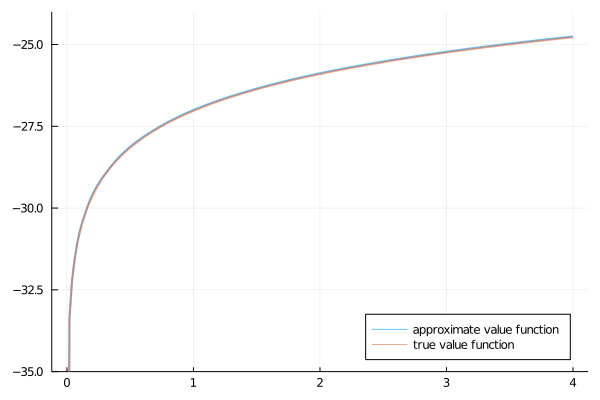

In [401]:
@time begin
initial_w = 5 * log.(p.y)
sol = solve_optgrowth(initial_w; p=p, basis=basis)
v_star_approx = sol.v_star
println("Converted in $(sol.results.iterations) to an ||residuals||_∞ of $(sol.results.residual_norm)")

plt = plot(ylim = (-35, -24), fmt = :png)
plot!(plt, p.y, v_star_approx, linewidth = 2, alpha = 0.6, label = "approximate value function")
plot!(plt, p.y, v_star.(p.y; p=p), linewidth = 2, alpha = 0.6, label = "true value function")
plot!(plt, legend = :bottomright)
end

## Computation (original: Interpolation approximation + Monte Carlo approximation)

The original notebook used the interpolation approximation for the function $w$ and also Monte Carlo approximation for the expectation.

In [392]:
# Bellman Operator in the original implementation
function T_orig(w; p, tol = 1e-10)
    @unpack β, u, f, ξ, y = p
    w_func = linear_interpolation(y, w, extrapolation_bc = Line())
    
    Tw = similar(w)
    σ = similar(w)
    for (i, y_val) in enumerate(y)
        results = Optim.optimize(c -> -(u(c; p=p) + β * mean(w_func.(f(y_val - c; p=p) .* ξ))), 1e-10, y_val - 1e-10)
        Tw[i] = -Optim.minimum(results)
        σ[i] = Optim.minimizer(results)
    end
    return (; w = Tw, σ = σ)
end

T_orig (generic function with 1 method)

In [395]:
function solve_optgrowth_orig(initial_w; p, iterations = 500, m = 3, show_trace = false)
    results = fixedpoint(x -> T_orig(x; p=p).w, initial_w, iterations=iterations, m=m, show_trace=show_trace)
    v_star = results.zero
    σ = T_orig(results.zero; p=p).σ
    return (;v_star=v_star, σ=σ, results=results)
end

solve_optgrowth_orig (generic function with 1 method)

Converted in 14 to an ||residuals||_∞ of 3.2168401276067016e-9
  0.175499 seconds (66.75 k allocations: 108.872 MiB, 8.13% gc time)


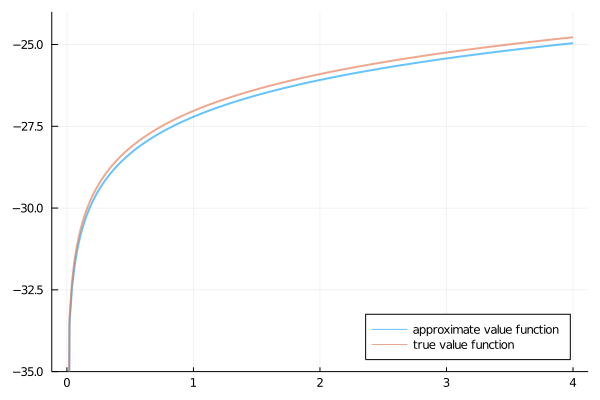

In [400]:
@time begin
initial_w = 5 * log.(p.y)
sol = solve_optgrowth_orig(initial_w; p=p)
v_star_approx = sol.v_star
println("Converted in $(sol.results.iterations) to an ||residuals||_∞ of $(sol.results.residual_norm)")

plt = plot(ylim = (-35, -24), fmt = :png)
plot!(plt, p.y, v_star_approx, linewidth = 2, alpha = 0.6, label = "approximate value function")
plot!(plt, p.y, v_star.(p.y; p=p), linewidth = 2, alpha = 0.6, label = "true value function")
plot!(plt, legend = :bottomright)
end

## Run-time comparision

In [398]:
@benchmark solve_optgrowth(initial_w; p=p, basis=basis)

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  536.319 ms … 619.670 ms  ┊ GC (min … max): 10.25% … 9.39%
 Time  (median):     575.805 ms               ┊ GC (median):    11.86%
 Time  (mean ± σ):   582.258 ms ±  27.008 ms  ┊ GC (mean ± σ):  11.16% ± 1.15%

  █                █      █ █ █            █ █               ██  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██ ▁
  536 ms           Histogram: frequency by time          620 ms <

 Memory estimate: 504.49 MiB, allocs estimate: 5718276.

In [399]:
@benchmark solve_optgrowth_orig(initial_w; p=p)

BenchmarkTools.Trial: 29 samples with 1 evaluation.
 Range (min … max):  166.661 ms … 185.903 ms  ┊ GC (min … max): 6.28% … 11.75%
 Time  (median):     176.626 ms               ┊ GC (median):    6.03%
 Time  (mean ± σ):   175.594 ms ±   5.395 ms  ┊ GC (mean ± σ):  6.37% ±  1.07%

  ▃       ▃         ▃                █ ▃          ▃              
  █▇▁▁▁▇▁▁█▁▁▁▁▁▁▁▁▇█▁▇▇▇▁▁▁▇▁▇▁▁▇▇▇▇█▇█▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▇▁▇▁▇ ▁
  167 ms           Histogram: frequency by time          186 ms <

 Memory estimate: 108.50 MiB, allocs estimate: 60885.

## Brief (naive?) conclusion

Looking at the run time, it seems the original implementation (linear interpolation + Monte Carlo approximation) is ~3X faster.
From some experiments, I feel the collocation method is significanly slowing down the computation.
On the other hand, the value function based on the collocation method + the quadrature method is closer to the true value function.